<a href="https://colab.research.google.com/github/Maryleen/Even-food-distribution-to-eradicate-hunger-and-wastage/blob/master/Food_demand_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solution 1: Food demand prediction model

A system that can predict demand of food and help farmers make informed decisions to prevent wastage. The solution to be developed is a predictive model that takes in features like price, inflation, population growth and output forecast for food in the coming year.

In [50]:
#Set up python packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
import datetime
from scipy import interpolate  #interpolation to fill missing data

from numpy import array #numerical computation

from sklearn.preprocessing import StandardScaler, MinMaxScaler #for the standardization of variables
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.vector_ar.var_model import VAR

In [51]:
#This code will help with loading the data
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pandas as pd
link_needed='https://drive.google.com/open?id=1li5Z9vXVqVYYTD8HI-_NhOCAD-psMEwi'
fluff, id = link_needed.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('food.csv')  

print (id) # Verify that you have everything after '='


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

1li5Z9vXVqVYYTD8HI-_NhOCAD-psMEwi


## Data preparation

Here we will explore the data and handle missing data points

In [52]:
#read the file

food = pd.read_csv('food.csv')
#pd.set_option("display.max_rows", None, "display.max_columns", None) #to view the entire dataset
food.head()

,Serial_Number,Year,Production_Quantity_tonnes,Yield_hg/ha,Food_Supply_Consumption_ha,Inflation,Population_Size_millions,Population_Age_percent,Consumption_Growth,Consumer_Price_Index,Unemployment_Rate_percent,Unnamed: 11,Population_Growth_percent,Food_Demand
0,1,1961,7384000,94667,780000,6.3,46.06,2.86,NaN,NaN,NaN,NaN,2.03,389817
1,2,1962,7583000,87665,865000,5.3,47.03,2.88,NaN,NaN,NaN,NaN,2.08,398027
2,3,1963,7783000,97166,801000,2.7,48.03,2.90,NaN,NaN,NaN,NaN,2.11,406490
3,4,1964,7982000,91747,870000,0.9,49.07,2.89,NaN,NaN,NaN,NaN,2.13,415292
4,5,1965,8182000,98697,829000,4.0,50.13,2.87,NaN,NaN,NaN,NaN,2.14,424263


In [53]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Serial_Number               58 non-null     int64  
 1   Year                        58 non-null     int64  
 2   Production_Quantity_tonnes  58 non-null     int64  
 3   Yield_hg/ha                 58 non-null     int64  
 4   Food_Supply_Consumption_ha  58 non-null     int64  
 5   Inflation                   58 non-null     float64
 6   Population_Size_millions    58 non-null     float64
 7   Population_Age_percent      58 non-null     float64
 8   Consumption_Growth          8 non-null      float64
 9   Consumer_Price_Index        12 non-null     float64
 10  Unemployment_Rate_percent   28 non-null     float64
 11  Unnamed: 11                 0 non-null      float64
 12  Population_Growth_percent   14 non-null     float64
 13  Food_Demand                 58 non-nu

In [54]:
##REMOVE NAMED AND UNNAMED EMPTY COLUMNS:

empty_cols = [col for col in food.columns if food[col].isnull().all()]
food.drop(empty_cols,
        axis=1,
        inplace=True)

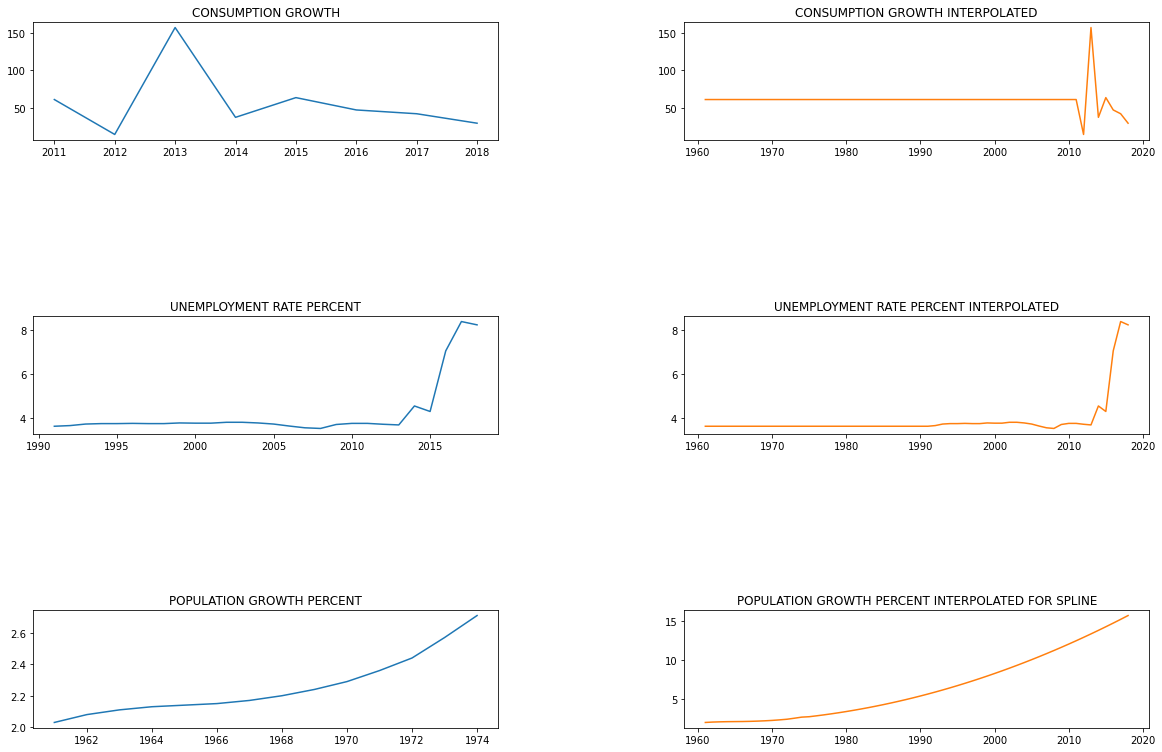

In [55]:
#Interpolation or filling of missing data - plots of original and final columns

food["Consumption_Growth_bfill"]= food.Consumption_Growth.fillna(method="bfill")
food["Unemployment_Rate_percent_bfill"]= food.Unemployment_Rate_percent.fillna(method="bfill")
food["Population_Growth_percent_spline"]= food.Population_Growth_percent.interpolate(method="spline",order=2)

fig, axs = plt.subplots(3,2,figsize=(20,10))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
axs[0, 0].plot(food["Year"],food.Consumption_Growth)
axs[0, 0].set_title('CONSUMPTION GROWTH')
axs[0, 1].plot(food.Year,food.Consumption_Growth_bfill, 'tab:orange')
axs[0, 1].set_title('CONSUMPTION GROWTH INTERPOLATED')

axs[1, 0].plot(food["Year"],food.Unemployment_Rate_percent)
axs[1, 0].set_title('UNEMPLOYMENT RATE PERCENT')
axs[1, 1].plot(food.Year,food.Unemployment_Rate_percent_bfill, 'tab:orange')
axs[1, 1].set_title('UNEMPLOYMENT RATE PERCENT INTERPOLATED')

axs[2, 0].plot(food["Year"],food.Population_Growth_percent)
axs[2, 0].set_title('POPULATION GROWTH PERCENT')
axs[2, 1].plot(food.Year,food.Population_Growth_percent_spline, 'tab:orange')
axs[2, 1].set_title('POPULATION GROWTH PERCENT INTERPOLATED FOR SPLINE')

plt.show()




In [56]:
#Replace the original columns with the newly filled columns and drop them from the dataframe

food["Consumption_Growth"] = food["Consumption_Growth_bfill"]
food["Unemployment_Rate_percent"] = food["Unemployment_Rate_percent_bfill"]
food["Population_Growth_percent"] = food["Population_Growth_percent_spline"]
food = food.drop(["Serial_Number","Consumption_Growth_bfill", "Unemployment_Rate_percent_bfill", "Population_Growth_percent_spline"], axis=1)  #axis=1 drops the entire columns

In [57]:
#food = food.drop(["Serial_Number"], axis=1)

In [58]:
#check for missing values in the dataset
if food.isnull().values.any() == True:  
  food = food.dropna(axis=1) #drop missing value if any along axis=1 (entire column with any missing data)

food.head()

,Year,Production_Quantity_tonnes,Yield_hg/ha,Food_Supply_Consumption_ha,Inflation,Population_Size_millions,Population_Age_percent,Consumption_Growth,Unemployment_Rate_percent,Population_Growth_percent,Food_Demand
0,1961,7384000,94667,780000,6.3,46.06,2.86,60.77,3.64,2.03,389817
1,1962,7583000,87665,865000,5.3,47.03,2.88,60.77,3.64,2.08,398027
2,1963,7783000,97166,801000,2.7,48.03,2.90,60.77,3.64,2.11,406490
3,1964,7982000,91747,870000,0.9,49.07,2.89,60.77,3.64,2.13,415292
4,1965,8182000,98697,829000,4.0,50.13,2.87,60.77,3.64,2.14,424263


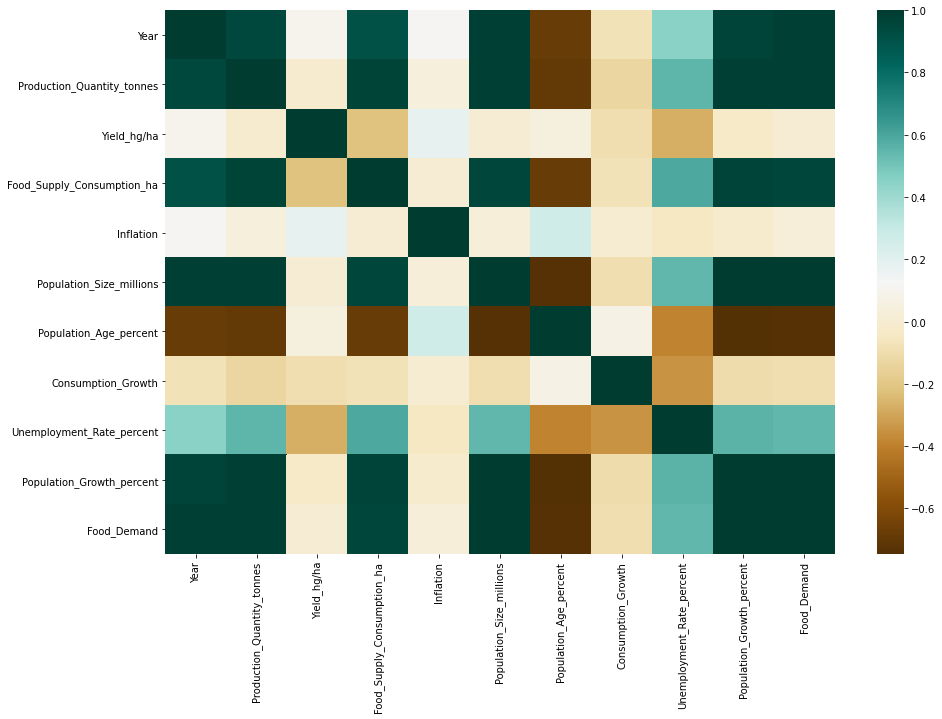

In [59]:
plt.figure(figsize=(15,10))
corr = food.corr()
sns.heatmap(corr, cmap='BrBG')

In [60]:
#data = food[['Year', 'Production_Quantity_tonnes',	'Yield_hg/ha'	, 'Food_supply_consumption_ha', 'Inflation', 'Food_demand']]
data = food
#set Year as index so as to make the dataset timeseries
data = data.set_index(['Year'])
data.tail()

,Production_Quantity_tonnes,Yield_hg/ha,Food_Supply_Consumption_ha,Inflation,Population_Size_millions,Population_Age_percent,Consumption_Growth,Unemployment_Rate_percent,Population_Growth_percent,Food_Demand
Year,,,,,,,,,,
2014,56328480,87217,6458435,9.0,176.40,2.75,37.03,4.56,13.794882,1492918
2015,57643271,92727,6216434,15.7,181.14,2.74,63.33,4.31,14.254945,1533034
2016,59565916,96584,6167296,16.5,185.96,2.75,46.88,7.06,14.723868,1573826
2017,59350878,89524,6629632,12.1,190.87,2.75,41.82,8.39,15.201651,1615381
2018,59475202,86789,6852857,11.4,195.87,2.75,29.20,8.24,15.688294,1657697


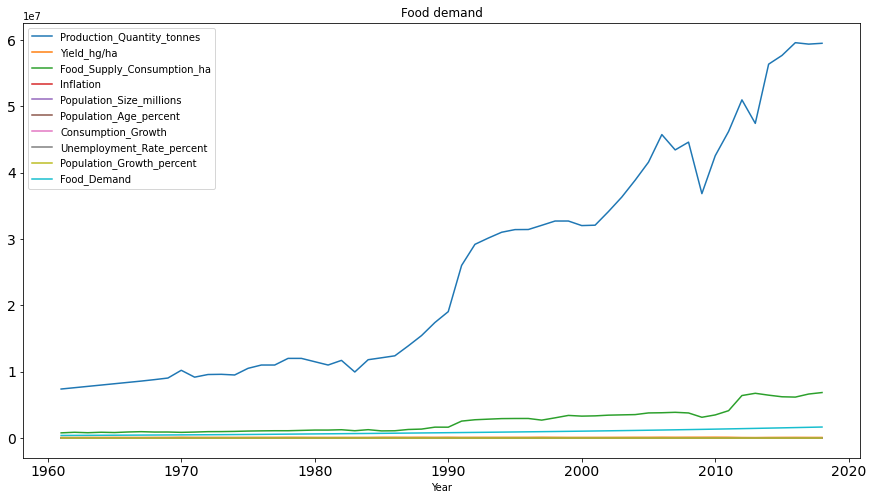

In [61]:
data.plot(figsize=(15,8), title= 'Food demand', fontsize=14)  #visualize the entire data against the Year

In [62]:
#pd.tools.plotting.lag_plot(food['Food_Demand'])
#checking for dependence (correlation) which is the first assumption for autoregressive models

food['Food_Demand'].corr(food['Food_Demand'].shift(4))

0.9999325253156837

## Linear regression model

In [63]:
### Create a simple linear regression model for the multivariate time series

#shifting the data back in time
data_shifted = data
for i in range(1,5):
  data_shifted["shift_{}".format(i)] = data.Food_Demand.shift(i)



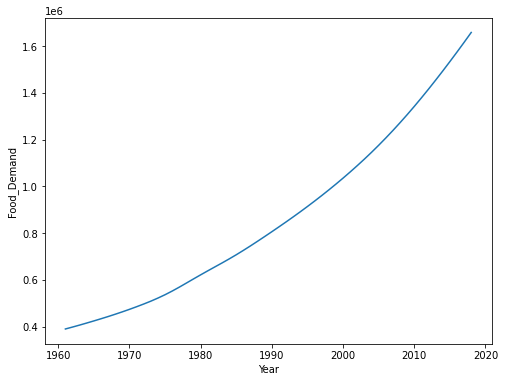

In [64]:
plt.figure(figsize=(8,6))
sns.lineplot(data.index, data.Food_Demand)

In [65]:
data_shifted = data_shifted.dropna()   #drop missing values

In [66]:
#Select X and y variables
data_shifted = data_shifted.reset_index()
X = data_shifted.drop(['Food_Demand'], axis=1) # data[['Year', 'Production_Quantity_tonnes',	'Yield_hg/ha'	, 'Food_supply_consumption_ha', 'Inflation', 'Population_growth_percent']]
y = data_shifted[['Food_Demand']]
X.head()

,Year,Production_Quantity_tonnes,Yield_hg/ha,Food_Supply_Consumption_ha,Inflation,Population_Size_millions,Population_Age_percent,Consumption_Growth,Unemployment_Rate_percent,Population_Growth_percent,shift_1,shift_2,shift_3,shift_4
0,1965,8182000,98697,829000,4.0,50.13,2.87,60.77,3.64,2.14,415292.0,406490.0,398027.0,389817.0
1,1966,8382000,92110,910000,9.7,51.22,2.89,60.77,3.64,2.15,424263.0,415292.0,406490.0,398027.0
2,1967,8581000,89572,958000,-3.7,52.34,2.89,60.77,3.64,2.17,433488.0,424263.0,415292.0,406490.0
3,1968,8801000,97572,902000,-0.5,53.51,2.88,60.77,3.64,2.20,442967.0,433488.0,424263.0,415292.0
4,1969,9040000,99779,906000,10.2,54.72,2.86,60.77,3.64,2.24,452869.0,442967.0,433488.0,424263.0


In [67]:
#standardize features by removing the mean and scaling to unit variance

ss_x = MinMaxScaler()
X = ss_x.fit_transform(X)
ss_y = MinMaxScaler()
y = ss_y.fit_transform(y)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, shuffle=False)

In [69]:
#Fitting the model to the data using Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
ts_cross = TimeSeriesSplit(n_splits=5)  #define crossvalidation for time series data
cv = cross_val_score(model, X_train, y_train, cv=ts_cross, scoring="neg_mean_squared_error")


In [71]:
y_pred = model.predict(X_test)

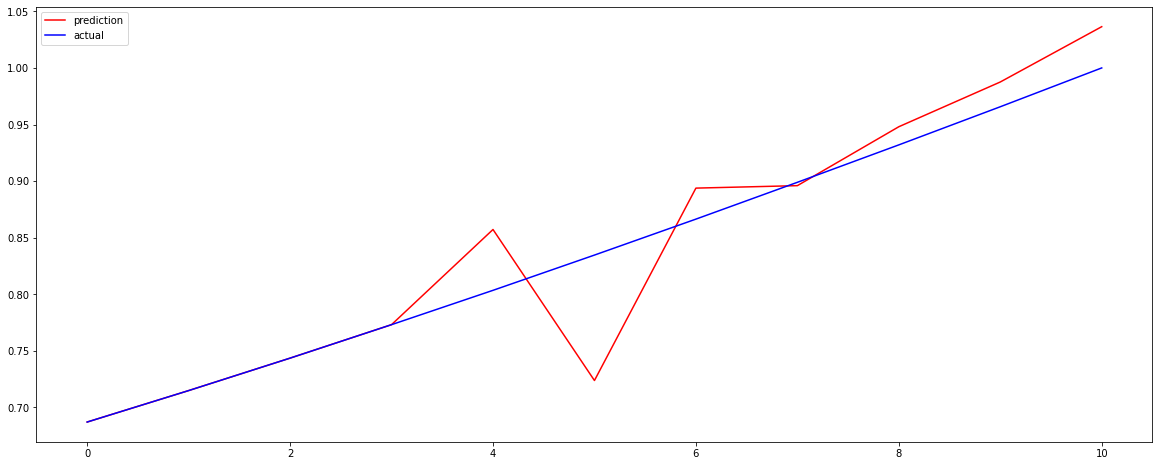

In [72]:
plt.figure(figsize=(20,8))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test, "b",label="actual")
plt.legend()

In [73]:
rms = sqrt(mean_squared_error(y_test, y_pred))
print(rms)

0.04044921555154772


In [74]:
# inverse transforms
x_inv = ss_x.inverse_transform(X_test)
y_inv = ss_y.inverse_transform(y_test)
yhat_plot = ss_y.inverse_transform(y_pred)
print (x_inv[:,0])

[2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018.]


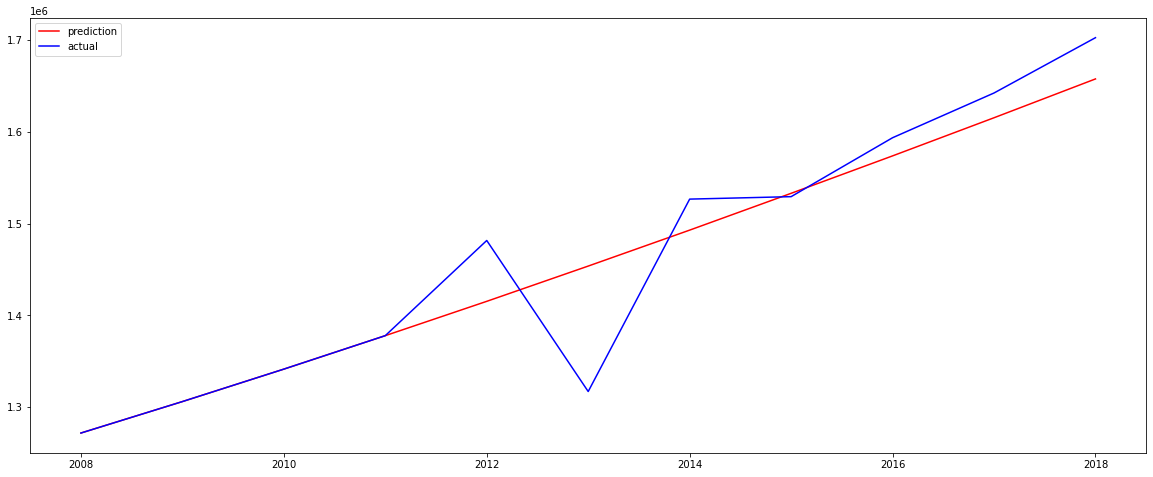

In [75]:
plt.figure(figsize=(20,8))
plt.plot(x_inv[:,0], y_inv, "r", label="prediction")
plt.plot(x_inv[:,0], yhat_plot, "b",label="actual")
plt.legend()

In [76]:
rms = sqrt(mean_squared_error(y_inv, yhat_plot))
print(rms)

49891.43773460775


## Vector Autoregression (VAR) model

In [120]:
data = data.dropna() #drop missing value if any
Train = data.iloc[0:50,:]  #select the first 50 rows
Test = data.iloc[50:,:] #select the remaining rows
print (len(Train))
print (len(Test))

50
4


In [78]:
y_hat_dummy = np.zeros(shape=(4,9))  #create a dummy variable which is same as the Test
y_hat = pd.DataFrame(y_hat_dummy)

In [79]:
Model = VAR(endog=Train)
model_fit = Model.fit()
y_pred = model_fit.forecast(model_fit.y, steps=len(Test))
print(y_pred)

[[ 7.00623651e+07  3.95743735e+04  9.89960120e+06 -1.42542520e+01
   1.81083581e+02  2.72450348e+00  6.37135660e+01  4.33699710e+00
   1.42466927e+01  1.53255782e+06  1.49291800e+06  1.45373300e+06
   1.41531000e+06  1.37790200e+06]
 [ 7.25317976e+07  2.14303432e+04  1.06366618e+07 -2.81711113e+01
   1.85792490e+02  2.69394152e+00  1.29784460e+02  4.54784544e+00
   1.47470549e+01  1.57240934e+06  1.53255782e+06  1.49291800e+06
   1.45373300e+06  1.41531000e+06]
 [ 8.40934329e+07  1.80351466e+04  1.15490205e+07 -3.78216501e+01
   1.90502012e+02  2.64468687e+00  5.52422064e+01  5.05717013e+00
   1.52620316e+01  1.61226818e+06  1.57240934e+06  1.53255782e+06
   1.49291800e+06  1.45373300e+06]
 [ 9.36055772e+07 -1.76341450e+04  1.37746236e+07 -6.84947453e+01
   1.95208374e+02  2.58840902e+00  1.00432018e+02  4.93576971e+00
   1.57996603e+01  1.65209958e+06  1.61226818e+06  1.57240934e+06
   1.53255782e+06  1.49291800e+06]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



In [80]:
y_pred_df = pd.DataFrame(data=y_pred)  #convert y_pred from numpy to dataframe

y_pred_df = y_pred_df.set_index(Test.index)  #set the same index as y_hat

y_pred_df.columns = Test.columns.values
y_pred_df.head()



,Production_Quantity_tonnes,Yield_hg/ha,Food_Supply_Consumption_ha,Inflation,Population_Size_millions,Population_Age_percent,Consumption_Growth,Unemployment_Rate_percent,Population_Growth_percent,Food_Demand,shift_1,shift_2,shift_3,shift_4
Year,,,,,,,,,,,,,,
2015,7.006237e+07,39574.373511,9.899601e+06,-14.254252,181.083581,2.724503,63.713566,4.336997,14.246693,1.532558e+06,1.492918e+06,1.453733e+06,1.415310e+06,1377902.0
2016,7.253180e+07,21430.343179,1.063666e+07,-28.171111,185.792490,2.693942,129.784460,4.547845,14.747055,1.572409e+06,1.532558e+06,1.492918e+06,1.453733e+06,1415310.0
2017,8.409343e+07,18035.146630,1.154902e+07,-37.821650,190.502012,2.644687,55.242206,5.057170,15.262032,1.612268e+06,1.572409e+06,1.532558e+06,1.492918e+06,1453733.0
2018,9.360558e+07,-17634.144993,1.377462e+07,-68.494745,195.208374,2.588409,100.432018,4.935770,15.799660,1.652100e+06,1.612268e+06,1.572409e+06,1.532558e+06,1492918.0


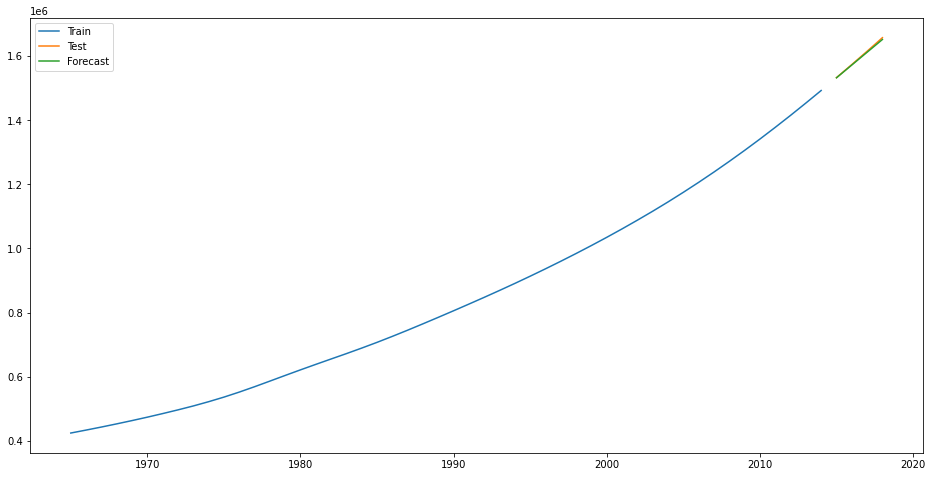

In [81]:
plt.figure(figsize=(16,8))
plt.plot(Train['Food_Demand'], label = 'Train')
plt.plot(Test['Food_Demand'], label = 'Test')
plt.plot(y_pred_df['Food_Demand'], label = 'Forecast')
plt.legend()
plt.show()

In [ ]:
for j in range (0, len(y_pred_df.columns.values)):
  for i in range (0, len(y_pred_df)):
    y_pred_df.iloc[i][j] = y_pred_df[i][j]
rms = sqrt(mean_squared_error(y_test, y_pred))
print(rms)

In [122]:

#compute the rmse
for i in y_pred_df.columns:
  print (i)
  print ('rmse value for', i, 'is: ', sqrt(mean_squared_error(y_pred_df[i], Test[i] )))    

Production_Quantity_tonnes
rmse value for Production_Quantity_tonnes is:  22909738.760333117
Yield_hg/ha
rmse value for Yield_hg/ha is:  78243.40739441047
Food_Supply_Consumption_ha
rmse value for Food_Supply_Consumption_ha is:  5139362.50657889
Inflation
rmse value for Inflation is:  54.240452792439186
Population_Size_millions
rmse value for Population_Size_millions is:  0.38871790898832037
Population_Age_percent
rmse value for Population_Age_percent is:  0.10072883879734494
Consumption_Growth
rmse value for Consumption_Growth is:  55.062357057240476
Unemployment_Rate_percent
rmse value for Unemployment_Rate_percent is:  2.661641511699549
Population_Growth_percent
rmse value for Population_Growth_percent is:  0.06452519286293337
Food_Demand
rmse value for Food_Demand is:  3288.407079642864
shift_1
rmse value for shift_1 is:  1726.509488048324
shift_2
rmse value for shift_2 is:  747.2737806966197
shift_3
rmse value for shift_3 is:  238.08840636746027
shift_4
rmse value for shift_4 is: 